### Convert and Yolact into ONNX and OpenVINO™

The yolact model is a simple, fully convolutional model for real-time instance segmentation

YOLACT is an acronym for "You Only Look At Coefficients," which reflects the core philosophy behind this state-of-the-art real-time instance segmentation model

Instance segmentation involves not only detecting objects in an image but also providing pixel-level segmentation masks for each individual object instance. This level of detail is crucial for various computer vision tasks such as object recognition, scene understanding, and robotic perception. However, instance segmentation is computationally intensive and typically requires complex algorithms that may not be suitable for real-time applications.


Key features and more details can be found in the original model [repository](https://github.com/dbolya/yolact).


This tutorial demonstrates step-by-step instructions on how to run YOLACT with OpenVINO. 

The tutorial consists of the following steps:
- Download the pretrained weights.
- Prepare the PyTorch model.
- Validate the original model.
- Convert the PyTorch model to ONNX.
- Convert the PyTorch model to Openvino IR.
- Validate the converted model.
- Run the model 

Installation
Before loading the YOLACT model, ensure that you have the necessary dependencies installed. The notebooks' requirements file covers pretty much all the dependencies, however it's missing only 2, which are listed below.  

In [1]:
%pip install -q cython
%pip install -q pycocotools
%pip install -q gdown

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Imports and settings for various libraries and modules. 
The `utils` directory contains various utility functions and configurations for the model. It provides functionalities related to image processing, model post-processing, configuration management, and integration with external tools.


- `cfg, set_cfg, mask_type` are configuration files  related functions to use the pretrained model config.
- the `SavePath` class is used for reading/writing models' files or paths.
- `InterpolateModule` module, which handles image interpolation or resizing operations.
- `gdown` is a library for downloading files from the internet, suggesting the usage of file downloading functionality.
- ` resnetBottleneck`  the ResNet model architecture.
- `Detect` is a module related to object detection functionality.
- `postprocess` and `output_utils` are output-related utility functions, such as post-processing and image transformation operations.
- `import MEANS, COLORS, STD` are additional configuration values, such as mean values, colors, and standard deviations.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
from data.config import cfg, set_cfg
from utils.functions import SavePath
import gdown
from os import path, makedirs
from yolact import Yolact
from utils import timer
from layers.output_utils import postprocess
from layers.output_utils import undo_image_transformation
from data.config import MEANS, COLORS, STD
import sys
sys.path.append('..')
from utils.notebook_utils import download_file
import openvino as ov



Downloading the Pretrained Weights
The YOLACT model comes with pretrained weights, which are trained on large-scale datasets such as COCO. You need to download the pretrained weights file before loading the model. You can obtain the weights from the official YOLACT repository or other reliable sources.

In [3]:
WEIGHTS_PATH = "weights"
if not path.exists(f"{WEIGHTS_PATH}"):
    makedirs(WEIGHTS_PATH)
# org model drive
# https://drive.google.com/file/d/1UYy3dMapbH1BnmtZU4WH1zbYgOzzHHf_/view
MODEL_DRIVE_ID = "1UYy3dMapbH1BnmtZU4WH1zbYgOzzHHf_"
MODEL_NAME = "yolact_base_54_800000"
output_path = f"{WEIGHTS_PATH}/{MODEL_NAME}.pth"
gdown.download(id=MODEL_DRIVE_ID, output=output_path, fuzzy=True)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UYy3dMapbH1BnmtZU4WH1zbYgOzzHHf_
From (redirected): https://drive.google.com/uc?id=1UYy3dMapbH1BnmtZU4WH1zbYgOzzHHf_&confirm=t&uuid=24e47e09-452a-4b9e-b1fa-26298eebfdf8
To: /Users/elkasabya2/Study/open-vino/notebooks/276-yolact-instance-segmentation-ov-demo/weights/yolact_base_54_800000.pth
100%|██████████| 204M/204M [00:59<00:00, 3.44MB/s] 


'weights/yolact_base_54_800000.pth'

The Config class is designed to provide configuration options and parameters for the YOLACT object detection model. It serves as a container for customizing the model's behavior and settings to meet specific requirements. Unlike the original implementation that utilized a parser for command-line execution, this class is more suitable for notebook environments where direct customization is preferred.

In [4]:
class YOLACTConfig:
    """
    The class is used to configure
    various settings and parameters for the YOLACT object detection model.
    The class encapsulates the configuration options for the model
    allowing users to easily customize the model's
    behavior and settings based on their specific needs.
    The original used a parser functionality to run the model from CLI
    , which is not suitable for a notebook.
    """

    def __init__(
        self,
        top_k=5,
        cuda=True,
        fast_nms=True,
        display_masks=True,
        display_bboxes=True,
        display_text=True,
        display_scores=True,
        display=False,
        shuffle=False,
        ap_data_file="results/ap_data.pkl",
        resume=False,
        max_images=-1,
        output_coco_json=False,
        bbox_det_file="results/bbox_detections.json",
        mask_det_file="results/mask_detections.json",
        config=None,
        output_web_json=False,
        web_det_path="web/dets/",
        no_bar=False,
        display_lincomb=False,
        benchmark=False,
        no_sort=False,
        seed=None,
        mask_proto_debug=False,
        crop=True,
        image=None,
        images=None,
        video=None,
        video_multiframe=1,
        score_threshold=0,
        dataset=None,
        detect=False,
    ):
        self.top_k = top_k
        self.cuda = cuda
        self.fast_nms = fast_nms
        self.display_masks = display_masks
        self.display_bboxes = display_bboxes
        self.display_text = display_text
        self.display_scores = display_scores
        self.display = display
        self.shuffle = shuffle
        self.ap_data_file = ap_data_file
        self.resume = resume
        self.max_images = max_images
        self.output_coco_json = output_coco_json
        self.bbox_det_file = bbox_det_file
        self.mask_det_file = mask_det_file
        self.config = config
        self.output_web_json = output_web_json
        self.web_det_path = web_det_path
        self.no_bar = no_bar
        self.display_lincomb = display_lincomb
        self.benchmark = benchmark
        self.no_sort = no_sort
        self.seed = seed
        self.mask_proto_debug = mask_proto_debug
        self.crop = crop
        self.image = image
        self.images = images
        self.video = video
        self.video_multiframe = video_multiframe
        self.score_threshold = score_threshold
        self.dataset = dataset
        self.detect = detect
        self.display_fps = False

Initializing the model using the default config for the pretrained model
1. An instance of the YOLACT model is created.
2. An instance of the `Config` class is created with specific configuration options.
3. The path to the trained model file is set.
4. A `SavePath` object is created from the model file path.



In [5]:
args = YOLACTConfig()
args.trained_model = "weights/" + MODEL_NAME + ".pth"
net = Yolact()
image_uri = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg"
image_uri = download_file(image_uri)
args.image = str(image_uri).split('/')[-1]
model_path = SavePath.from_str(args.trained_model)
args.config = model_path.model_name + "_config"
args.mask_proto_debug = False
set_cfg(args.config)
net.detect.use_fast_nms = args.fast_nms

coco_bike.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

5. The pretrained weights are loaded into the YOLACT model.
6. The YOLACT model is put in evaluation mode.

In [6]:
net.load_weights(args.trained_model)
net.eval()

The   `prep_display` function is responsible for preparing and displaying object detection results on an image. It takes the detection results obtained from a model, the input image, image dimensions, and various optional parameters.

In [7]:
def prep_display(net, dets_out, img, h, w, undo_transform=True,
                 class_color=False, mask_alpha=0.45, fps_str=''):
    """
    Prepare and display object detection results.

    Args:
        dets_out (dict): detection results obtained from a model.
        img (numpy.ndarray): Input image as a NumPy array.
        h (int): Height of the input image.
        w (int): Width of the input image.
        undo_transform (bool, optional): Whether to
        undo the image transformation. Defaults to True.
        class_color (bool, optional): Whether to use class-specific
        colors for visualization. Defaults to False.
        mask_alpha (float, optional): Alpha value
        for blending masks with the image. Defaults to 0.45.

    Returns:
        numpy.ndarray: The processed image with detection results.
    """
    if undo_transform:
        img_numpy = undo_image_transformation(img, w, h)
        img_gpu = torch.Tensor(img_numpy).cuda()
    else:
        img_gpu = img / 255.0
        h, w, _ = img.shape
    
    with timer.env('Postprocess'):
        save = cfg.rescore_bbox
        cfg.rescore_bbox = True
        
        preds = net.detect({'loc': dets_out[0], 'conf': dets_out[1], 'mask':dets_out[2], 'priors': dets_out[3], 'proto': dets_out[4]}, net)

        t = postprocess(preds, w, h, visualize_lincomb=args.display_lincomb,
                        crop_masks=args.crop,
                        score_threshold=args.score_threshold)
        cfg.rescore_bbox = save

    with timer.env('Copy'):
        idx = t[1].argsort(0, descending=True)[:args.top_k]
        
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][idx]
        classes, scores, boxes = [x[idx].cpu().numpy() for x in t[:3]]

    num_dets_to_consider = min(args.top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < args.score_threshold:
            num_dets_to_consider = j
            break

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)
        
        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    if args.display_masks and cfg.eval_mask_branch and num_dets_to_consider > 0:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]
        
        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        # colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        colors = torch.cat(
            [
                torch.FloatTensor(get_color(j, on_gpu=img.device.index)).view(
                    1, 1, 1, 3
                )
                for j in range(num_dets_to_consider)
            ],
            dim=0,
        )

        masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1
        
        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(
                num_dets_to_consider - 1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand
    
    if args.display_fps:
        # Draw the box for the fps on the GPU
        font_face = cv2.FONT_HERSHEY_DUPLEX
        font_scale = 0.6
        font_thickness = 1

        text_w, text_h = cv2.getTextSize(fps_str, font_face, font_scale, font_thickness)[0]

        img_gpu[0:text_h + 8, 0:text_w + 8] *= 0.6  # 1 - Box alpha


    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    if args.display_fps:
        # Draw the text on the CPU
        text_pt = (4, text_h + 2)
        text_color = [255, 255, 255]

        cv2.putText(img_numpy, fps_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
    
    if num_dets_to_consider == 0:
        return img_numpy

    if args.display_text or args.display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j)
            score = scores[j]

            if args.display_bboxes:
                cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)

            if args.display_text:
                _class = cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if args.display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.6
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
    
    return img_numpy

The FastBaseTransform class enables fast image transformations on the GPU, specifically designed for production use. It sets up mean and standard deviation values for image normalization and supports basic configuration settings. When an image tensor is passed through the forward method, it undergoes operations such as permutation, resizing, normalization (mean subtraction and division by standard deviation), and channel reordering. The transformed image tensor is returned as output. In summary, FastBaseTransform optimizes image transformations on the GPU, catering to production environments, and offering support for essential configuration settings.

In [8]:
class FastBaseTransform(torch.nn.Module):
    """
    Transform that does all operations on the GPU for super speed.
    This doesn't suppport a lot of config settings
    and should only be used for production.
    Maintain this as necessary.
    """

    def __init__(self):
        super().__init__()
        
        # self.mean = torch.Tensor(MEANS).float().cuda()[None, :, None, None]
        # self.std = torch.Tensor(STD).float().cuda()[None, :, None, None]
        self.mean = torch.Tensor(MEANS).float()[None, :, None, None]
        self.std = torch.Tensor(STD).float()[None, :, None, None]
        self.transform = cfg.backbone.transform

    def forward(self, img):
        self.mean = self.mean.to(img.device)
        self.std = self.std.to(img.device)

        # img assumed to be a pytorch BGR image with channel order [n, h, w, c]
        if cfg.preserve_aspect_ratio:
            raise NotImplementedError

        img = img.permute(0, 3, 1, 2).contiguous()
        img = F.interpolate(img, (cfg.max_size, cfg.max_size),
                            mode="bilinear", align_corners=False)

        if self.transform.normalize:
            img = (img - self.mean) / self.std
        elif self.transform.subtract_means:
            img = img - self.mean
        elif self.transform.to_float:
            img = img / 255

        if self.transform.channel_order != "RGB":
            raise NotImplementedError

        img = img[:, (2, 1, 0), :, :].contiguous()

        # Return value is in channel order [n, c, h, w] and RGB
        return img

Validating the original model involves running it on an image and analyzing the output to evaluate its performance and accuracy in predicting objects or features. This step ensures the model's effectiveness and reliability before applying it to other tasks or applications.


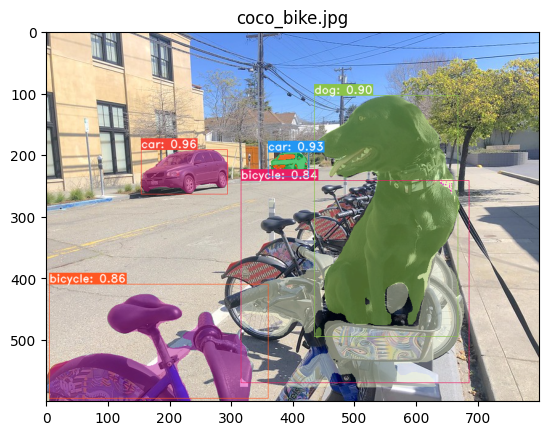

In [9]:
def evalimage(net, path):
    """
    Perform inference using the original model
    on an input image and display the results.
    Args:
        path (str): Path to the input image file.
    Returns:
        None
    """
    frame = torch.from_numpy(cv2.imread(path)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)
    # img_numpy = prep_display(preds, frame, None, None, undo_transform=False)
    img_numpy = prep_display(net, preds, frame, None, None, undo_transform=False)
    img_numpy = img_numpy[:, :, (2, 1, 0)]
    plt.imshow(img_numpy)
    plt.title(path)
    plt.show()


with torch.no_grad():
    evalimage(net, args.image)

Creating a directory for the onnx model

In [10]:
MODELS_PATH = "models"
if not path.exists(f"{MODELS_PATH}"):
    makedirs(MODELS_PATH)
onnx_model_path = f"{MODELS_PATH}/{MODEL_NAME}.onnx"
ov_model_xml_path = f"{MODELS_PATH}/{MODEL_NAME}.xml"

Exporting the model into XML format 

In [11]:
if path.exists(f"{MODELS_PATH}"):
    net.eval()
    input_names = ["actual_input"]
    output_names = ["output"]
    frame = torch.from_numpy(cv2.imread(args.image)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)
    if not path.exists(ov_model_xml_path):
        ov_model = ov.convert_model(net, example_input=batch)
        ov.save_model(ov_model, ov_model_xml_path)

/Users/elkasabya2/Study/open-vino/notebooks/276-yolact-instance-segmentation-ov-demo/yolact.py:233: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.last_conv_size != (conv_w, conv_h):


Compile the converted model

In [12]:
core = ov.Core()
compiled_model = core.compile_model(ov_model_xml_path)

Converting OpenVINO model output to tensors to be able to use the org model functionality for displaying the output


In [13]:
def preds_to_tensor(preds):
    """Converts the openvino-model output into tensor.
    to be able to use them in displaying the image
    Args:
        preds (dict): containing the predictions from the OpenVINO model.
    Returns:
        list: A list containing the tensors of the preds
    """
    converted_preds = [_ for i in range(5)]
    idx = 0
    for batch in preds.values():
        converted_preds[idx] = torch.from_numpy(np.array(batch))
        idx += 1
    return converted_preds

In [14]:
def image_inference(path):
    """
    inference using OpenVINO on an input image and display the results.
    Args:
        path (str): Path to the input image file.
    Returns:
        None
    """
    frame = torch.from_numpy(cv2.imread(path)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    openvino_preds = compiled_model.infer_new_request([batch.detach().numpy()])
    openvino_preds = preds_to_tensor(openvino_preds)
    img_numpy = prep_display(net, openvino_preds, frame, None, None, undo_transform=False)
    img_numpy = img_numpy[:, :, (2, 1, 0)]
    plt.imshow(img_numpy)
    plt.title(path)
    plt.show()

Running the OpenVINO Model

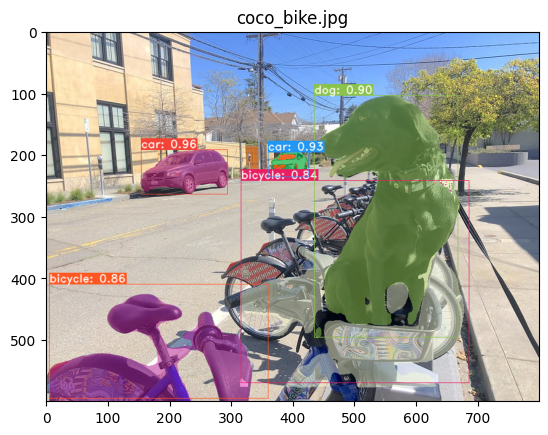

In [15]:
image_inference(args.image)